# Set Up
if you don't have the libraries just remove the hashtag in the cell below 

In [206]:
#! pip install numpy pandas altair seaborn scikit-learn xgboost

# **1 - Reading Data**

In [207]:
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns    
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px         

In [208]:
train1 = pd.read_csv("../data/train1.csv")
train2 = pd.read_csv("../data/train2.csv")
train = pd.concat([train1,train2])

test = pd.read_csv("../data/test.csv")



# **2 - EDA**

**1.1 - Basic Data Understanding**

We'll take a peak of the data set to aquire basic understanding of it

In [209]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


**2.2 -  Cleaning The Data**

Now, well check for null values

In [210]:
train.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [211]:
test.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

There are 201 missing values in the BMI column in the train data set.
That can be handled in various ways. Here, we will fill the missing data in the BMI column with the average of the same column.

In [212]:
bmi_mean = train.bmi.mean()
train['bmi'] = train.bmi.fillna(bmi_mean)
train.bmi.isnull().sum()

0

**2.3 - Data Visuilization**

First, we'll use a heatmap to see the correlation between the numerical variables 

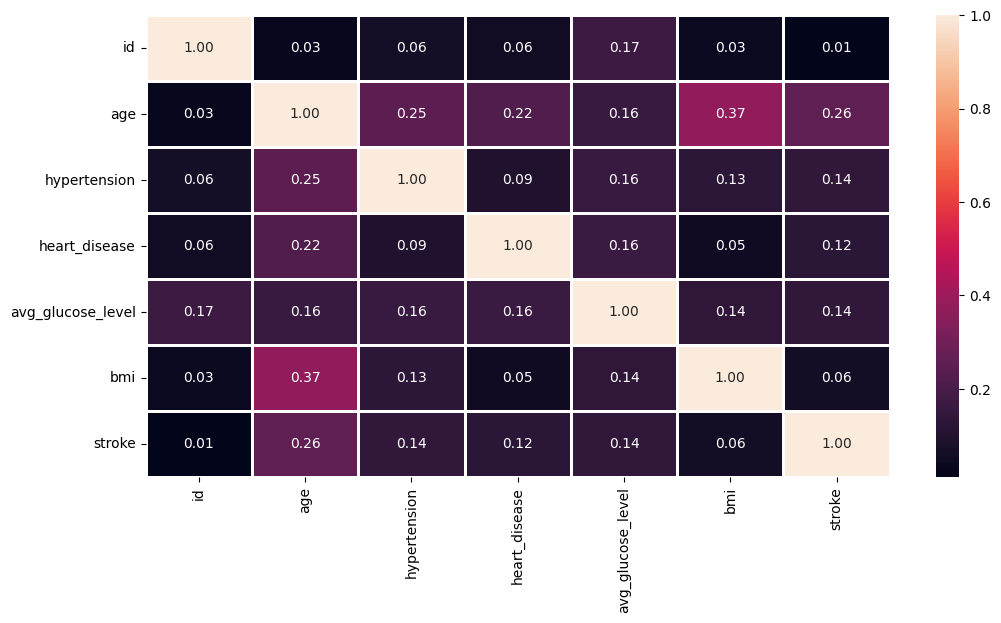

In [213]:
plt.figure(figsize=(12, 6))
sns.heatmap(train.corr(numeric_only=True),
            fmt = '.2f', #to covert to float
            linewidths = 2,
            annot = True); #to show values

From the previous visuilization, we can have a general understanding of the relationship between the numerical variables. However we want to further investigate in details the relationship between each variable and the stroke variable. 

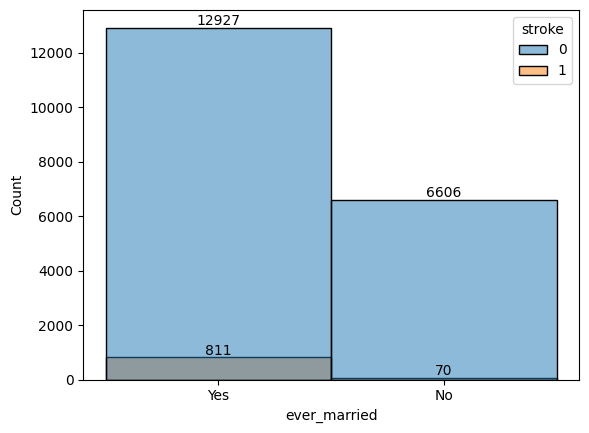

In [214]:
hs = sns.histplot(data=train, x="ever_married", hue = "stroke")
hs.bar_label(hs.containers[0]); #to show number of stroke data
hs.bar_label(hs.containers[1]); #to show number of marriage data
plt.show()

The data show higher stroke rates among people who have ever been married.
About 6.27% who have ever been married had a stroke, and about 1.06% among people who have not.

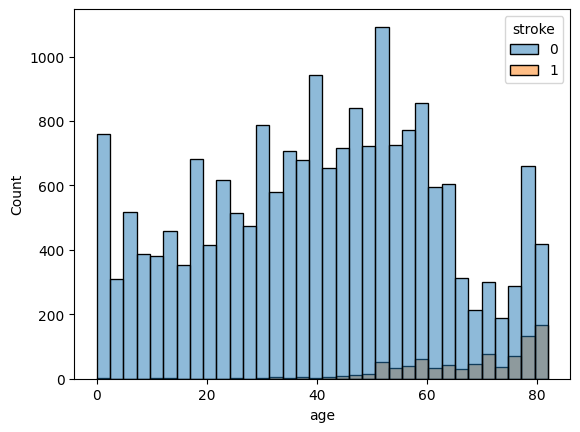

In [215]:
hs = sns.histplot(data=train, x="age", hue = "stroke")
plt.show()

There's an obvious trend here; elder people are more septeable to having strokes.

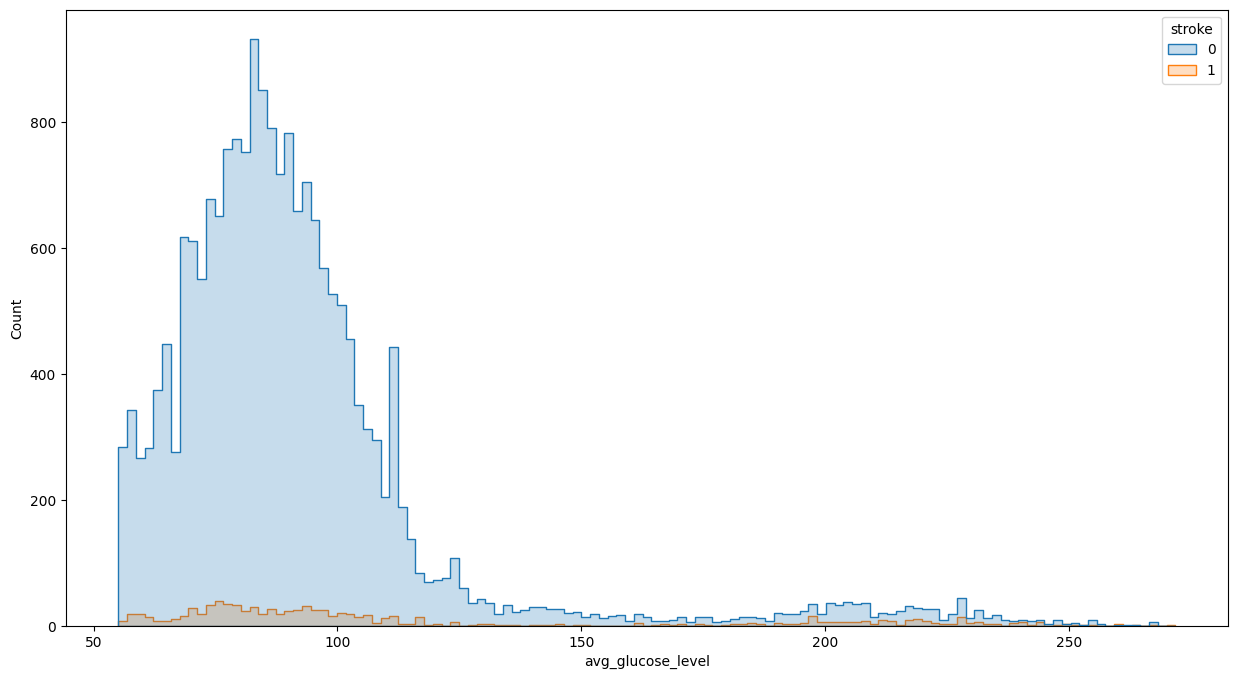

In [216]:
plt.figure(figsize = (15, 8))
sns.histplot(data=train, x="avg_glucose_level", hue="stroke", element="step")
plt.show()

There is not a strong corellation between the average glucose level and having a stroke.

[Text(0, 0, '450'), Text(0, 0, '431')]

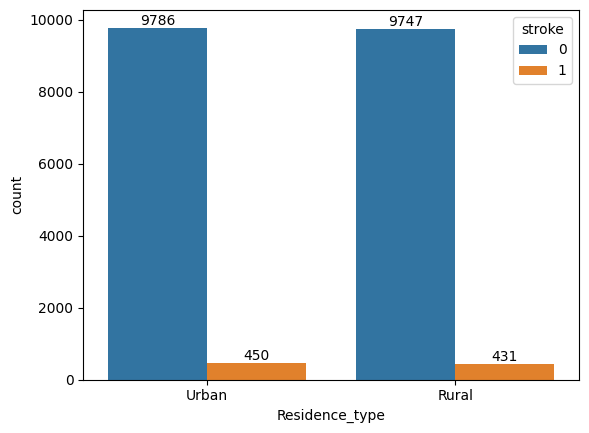

In [217]:
ax = sns.countplot(data=train, x="Residence_type",hue = "stroke")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])


The stroke proportion difference between urban redsidents and rural residents is negligible, thus suggesting that there is no correlation.

[Text(0, 0, '768'), Text(0, 0, '113')]

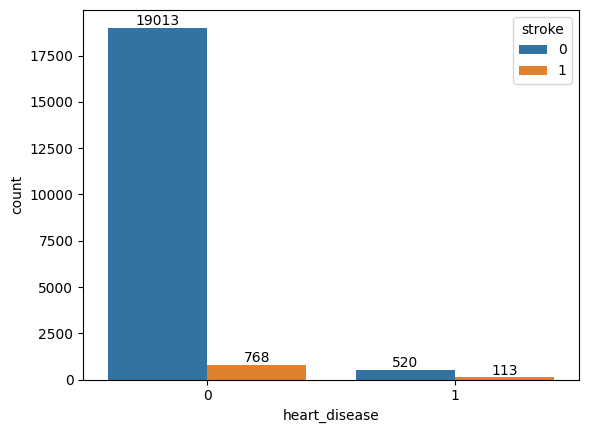

In [218]:
ax = sns.countplot(data=train, x="heart_disease",hue = "stroke")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])


Only 4.04% of people with heart diseases have had a stroke, and 21.73% of people who have heart diseases have had a stroke. Therefore, there is strong correlation between the two.

[Text(0, 0, '687'), Text(0, 0, '194')]

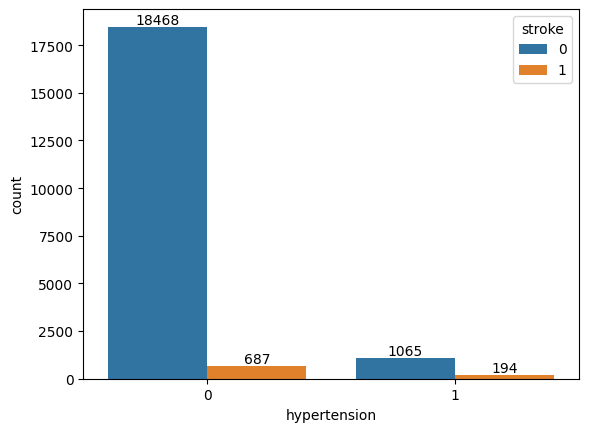

In [219]:
ax = sns.countplot(data=train, x="hypertension",hue = "stroke")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

There's greater stroke proportion among people with hypertension that those who don't have hypertension, thus showing strong correlation.

<Axes: xlabel='bmi', ylabel='Count'>

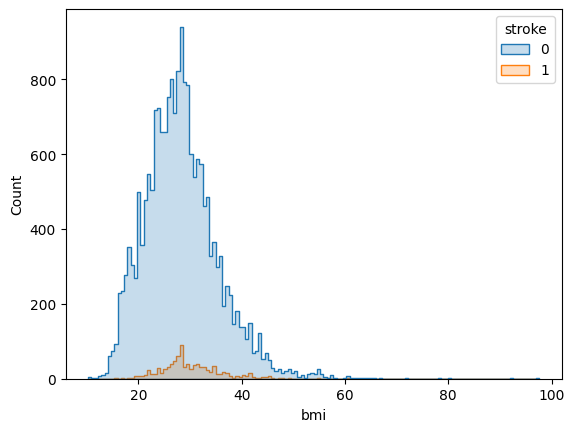

In [220]:
sns.histplot(train, x="bmi", hue="stroke", element="step")

There does not seem to be a noticable trend; the stroke data, as the bmi data, is normally distibuted. The acute peak at the mean could be explained by the fact that we replaced the missing values with the mean.

# **3 - Featuer Engineering**

Here, we will be converting the catagorical values into numerical ones.

In [221]:
#for the train data set
train = train.drop(columns=['id'])
train['gender'] = train['gender'].apply(lambda x: 0 if x == 'Male' else 1)
train['ever_married'] = train['ever_married'].apply(lambda x: 0 if x == 'yes' else 1)
train['Residence_type'] = train['Residence_type'].apply(lambda x: 0 if x == 'Urban' else 1)
train['work_type'].replace(train['work_type'].unique(),
                        [0, 1, 2, 3, 4], inplace=True)
train['smoking_status'].replace(train['smoking_status'].unique(),
                        [0, 1, 2, 3], inplace=True)

In [222]:
#for the test data set
test = test.drop(columns=['id'])
test['gender'] = test['gender'].apply(lambda x: 0 if x == 'Male' else 1)
test['ever_married'] = test['ever_married'].apply(lambda x: 0 if x == 'yes' else 1)
test['Residence_type'] = test['Residence_type'].apply(lambda x: 0 if x == 'Urban' else 1)
test['work_type'].replace(test['work_type'].unique(),
                        [0, 1, 2, 3, 4], inplace=True)
test['smoking_status'].replace(test['smoking_status'].unique(),
                        [0, 1, 2, 3], inplace=True)

# **4 - Model**

In [223]:
#spliting data
X = train.loc[:,train.columns != 'stroke']
y = train['stroke']
train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [224]:
#modeling
import xgboost as xgb

# Instantiate the model with tuned hyperparameters
model = xgb.XGBClassifier(
    seed=42,
    learning_rate=0.15,  # Adjust the learning rate 
    n_estimators=100,  # sets the number of estimators
    max_depth=5,  # Adjust the maximum depth of each tree 
    subsample=0.8,  # Adjust the subsample ratio 
    colsample_bytree=0.8,  # Adjust the column subsample ratio 
    random_state=42, #random seed
)

In [225]:
# Fit the model with data
model.fit(
    train_set_x, train_set_y,
    eval_set=[(train_set_x, train_set_y), (test_set_x, test_set_y)],
    verbose=False,
    early_stopping_rounds=10 
)

c:\Users\zaido\.conda\envs\jypyter\Lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [226]:
best_n_rounds = model.best_iteration

y_pred = model.predict(test_set_x, ntree_limit=best_n_rounds)

c:\Users\zaido\.conda\envs\jypyter\Lib\site-packages\xgboost\core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



# **5 - Submission**

In [227]:
test_sub = pd.read_csv('../data/test.csv')
test_sub['stroke'] = model.predict_proba(test)[:,1]

In [228]:
from pandas import DataFrame

In [229]:
sub = DataFrame()
sub['id'] = test_sub['id']
sub['stroke'] = test_sub['stroke']
sub.to_csv('../data/submission.csv',index=False)

----------------------------------------------------------------------------

In [230]:
fig = px.scatter_3d(train, x='age', y='avg_glucose_level', z='bmi',
              color='stroke')
fig.show()

In [231]:
fig=px.histogram(train, x="bmi", color="stroke",barmode='group',template='plotly_dark',text_auto=True)
fig.update_layout(yaxis_title="Number of  People")
fig.update_layout(font_color='lavender',
                  legend_title_font_color="magenta",
                  yaxis=dict(tickfont=dict(size=15), titlefont=dict(size=20)),
                  xaxis=dict(tickfont=dict(size=15), titlefont=dict(size=20)),
                  legend_font_size=12)
newnames = {'0': 'No', '1': 'Yes'}
fig.for_each_trace(lambda t: t.update(name=newnames[t.name],
                                      legendgroup=newnames[t.name],
                                      hovertemplate=t.hovertemplate.replace(
                                          t.name, newnames[t.name])))
fig.show()

<Axes: xlabel='hypertension', ylabel='Density'>

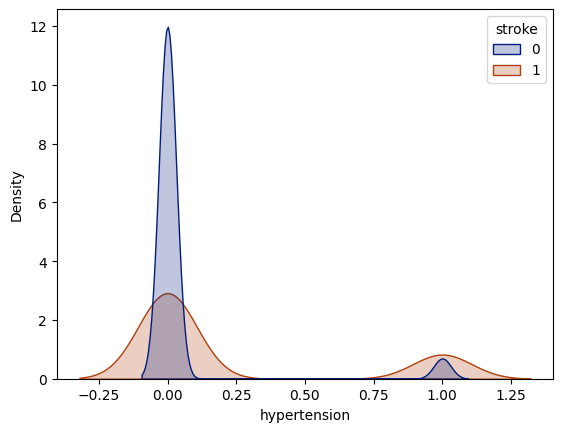

In [232]:
sns.kdeplot(
    data=train, x="hypertension",hue = "stroke",
    fill=True,common_norm=False, palette="dark"
)